In [402]:
import numpy as np
import lightkurve as lk
import astropy.units as u
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

In [403]:
TARGET = "HD 191306"
search = lk.search_lightcurvefile(TARGET, cadence='long')
print(search)

SearchResult containing 1 data products.

 #   observation   target_name                     productFilename                     distance
--- -------------- ----------- ------------------------------------------------------- --------
  0 TESS Sector 13   101654574 tess2019169103026-s0013-0000000101654574-0146-s_lc.fits      0.0


In [404]:
file = search.download_all()
lc = file.stitch().remove_outliers().remove_nans()

/Users/cooperdoyle/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


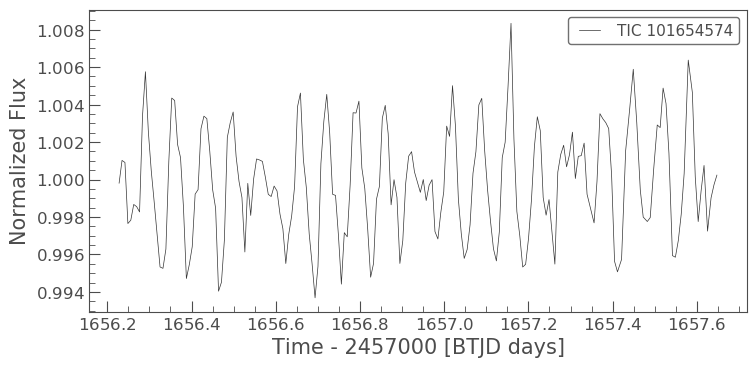

In [405]:
lc = lc[0:1000]
lc = lc[0::5]
lc.plot()

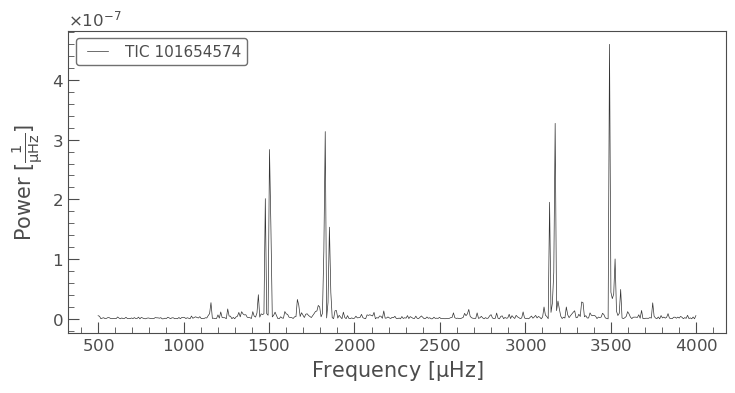

In [406]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=500, maximum_frequency=4000)
pg.plot();

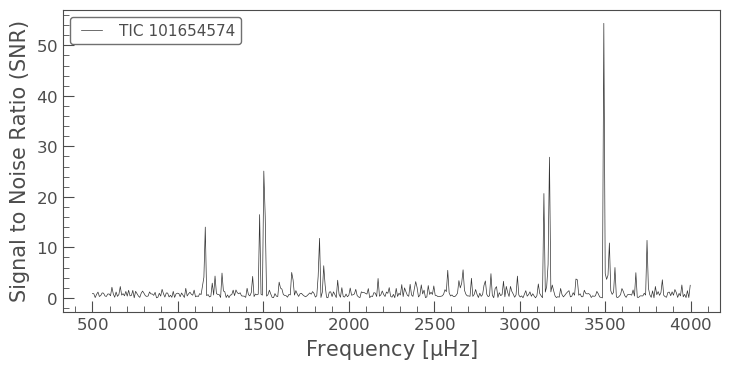

In [407]:
snr = pg.flatten()
seis = snr.to_seismology()
seis.periodogram.plot();

numax_guess =  3465.0 uHz


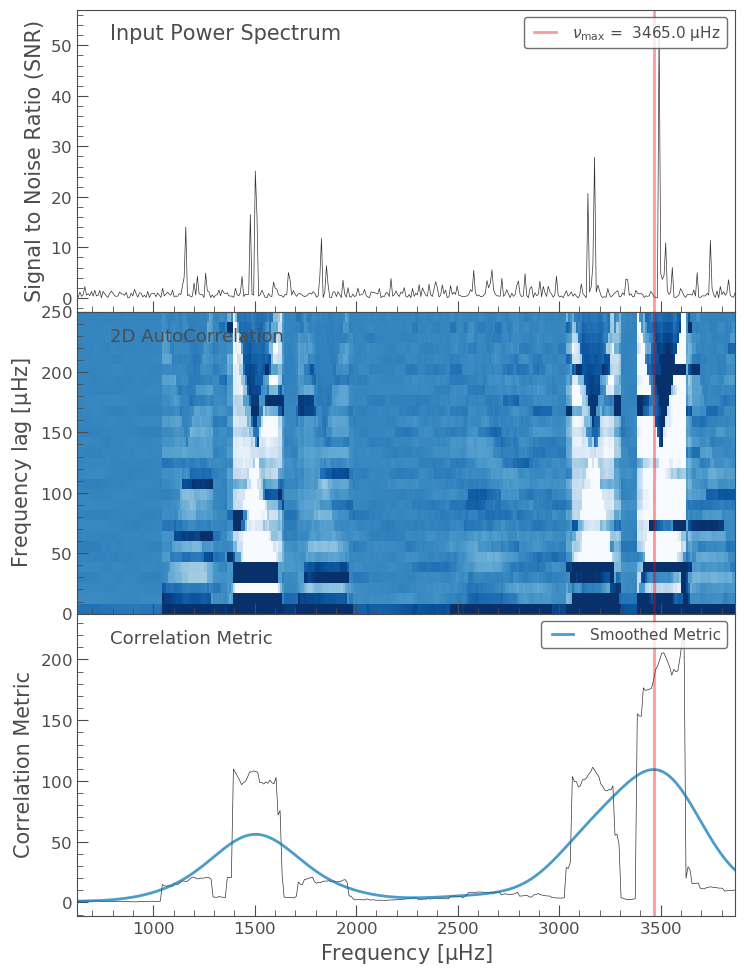

In [408]:
numax_guess = seis.estimate_numax()
print("numax_guess = ", numax_guess)
seis.diagnose_numax();

In [409]:
# Make sure that all the data have the right type
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)

# Convert to ppm
y = (y - 1) * 1e6
yerr *= 1e6

# This will be useful for converting between uHz and 1/d for frequencies
uHz_conv = u.uHz.to(1/u.day)

# Build the model in PyMC3
with pm.Model() as gp_model:
    
    # The mean stellar flux (relative to the normalized baseline) in ppm
    mean = pm.Normal("mean", mu=0, sd=np.std(y))
    
    # A jitter term to capture underestimated error bars and model misspecification
    logs2 = pm.Normal("logs2", mu=np.log(np.mean(yerr**2)), sd=10.0)
    
    # The kernel captures the power excess and it has 3 parameters:
    #
    # a: The amplitude of the variability (in ppm^2);
    # Q: The quality factor of the power envelope (constrained to be >0.5);
    # w: The central frequency of the power excess (in uHz);
    #
    # We will interpret w as nu_max
    
    # Guess mean Q
    logQ_peak_init = 1.0
    # Convert mean log(w) frequency to log(1/d)
    logw_peak_init = np.log(2*np.pi*uHz_conv*numax_guess.value)
    # Mean log(a) has a normally distributed prior around log(variance(y)) 
    loga_peak = pm.Normal("loga_peak", mu=np.log(np.var(y)), sd=10.0)
    # log(numax) has a normally distributed prior around the guess
    lognumax = pm.Normal("lognumax", mu=np.log(numax_guess.value), sd=500)
    # Transform the prior to linear
    numax = pm.Deterministic("numax", tt.exp(lognumax))
    # Extract prior of mean w0 in terms of numax
    w0_peak = pm.Deterministic("w0_peak", 2*np.pi*uHz_conv*numax)
    # Mean log(Q) has a normally distributed prior
    logQ_peak = pm.Normal("logQ", mu=logQ_peak_init, sd=2.0)
    # Extract prior for mean Q
    Q_peak = pm.Deterministic("Q_peak", 0.5+tt.exp(logQ_peak))
    # Mean log(S)
    logS_peak = loga_peak - tt.log(w0_peak * Q_peak)

    kernel = xo.gp.terms.SHOTerm(log_S0=logS_peak, w0=w0_peak, Q=Q_peak)
    
    # We put this together and evaluate the GP likelihood
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2))
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Then we maximize the log posterior to find an estimate of the maximum
    # a posteriori (map) parameters. Note: The order of these optimizations
    # has been chosen to work for this problem using a combination of intution
    # and trial and error.
    gp_map_soln = gp_model.test_point
    '''
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[logs2])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga_peak])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[lognumax])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean, logs2])
    '''
    gp_map_soln = xo.optimize(gp_map_soln)

optimizing logp for variables: [logQ, lognumax, loga_peak, logs2, mean]
162it [00:00, 597.23it/s, logp=-1.823000e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: -1887.9875133299847 -> -1822.999948738984


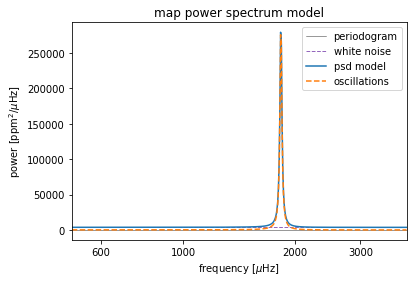

In [410]:
import matplotlib.pyplot as plt

var_ppm = np.mean(yerr**2) + np.exp(gp_map_soln["logs2"])
wn = 0.25*(x.max() - x.min()) * var_ppm / len(x)
logf = np.log10(pg.frequency.value)

plt.plot(logf, pg.power.value, "k", lw=0.5, alpha=0.8, label="periodogram")
plt.axhline(wn, lw=1, color="C4", ls="dashed", label="white noise")

label = "oscillations"
with gp_model:
    psd = gp.kernel.psd(2*np.pi*pg.frequency.to(1/u.day).value)
    plt.plot(logf, xo.eval_in_model(psd, gp_map_soln) + wn, label="psd model")
    term = gp.kernel
    psd = term.psd(2*np.pi*pg.frequency.to(1/u.day).value)
    plt.plot(logf, xo.eval_in_model(psd, gp_map_soln), "--", label=label)

plt.xlim(logf.min(), logf.max())
plt.xticks(np.log10([600, 1000, 2000, 3000]))
plt.gca().set_xticklabels(["600", "1000", "2000", "3000"])
plt.legend(fontsize=10, loc=1)
plt.xlabel("frequency [$\mu$Hz]")
plt.ylabel("power [ppm$^2/\mu$Hz]")
plt.title("map power spectrum model", fontsize=12);

In [411]:
# Make a true linear space of x values
true_x = np.linspace(x[0], x[-1], len(x))

In [412]:
with gp_model:
    mu, var = xo.eval_in_model(
        gp.predict(true_x, return_var=True, predict_mean=True), gp_map_soln
    )

Text(0, 0.5, 'y')

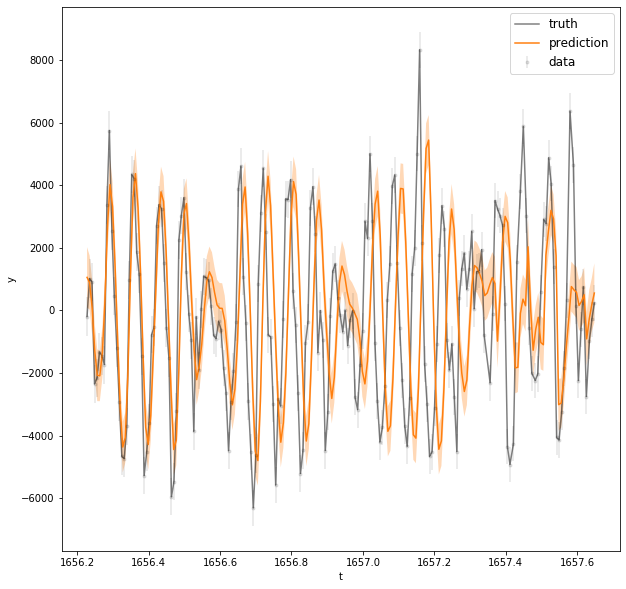

In [419]:
plt.figure(figsize=(10,10))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, alpha = 0.1, label="data")
plt.plot(x, y, "k", lw=1.5, alpha=0.5, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_x, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_x, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")

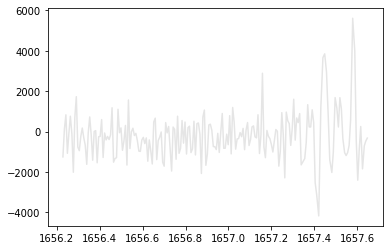

In [420]:
# Now compute the residuals
with gp_model:
    mu, var = xo.eval_in_model(
        gp.predict(x, return_var=True, predict_mean=True), gp_map_soln
    )

res = y - mu

plt.plot(x, res, "k", lw=1.5, alpha=0.1, label="truth")

In [421]:
# Fit the box least squares algorithm
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

model = BoxLeastSquares(x * u.day, res, dy=yerr)
periodogram = model.autopower(0.2)

Peak: 0.4540859174468674 d


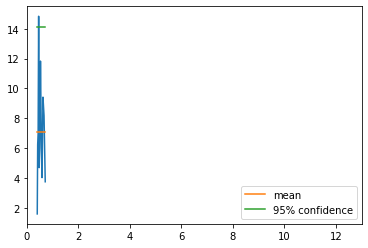

In [422]:
plt.plot(periodogram.period, periodogram.power)
avg_bls_power = np.mean(periodogram.power)
std_bls_power = np.std(periodogram.power)
plt.plot(periodogram.period, [avg_bls_power for i in range(len(periodogram.period))], label='mean')
plt.plot(periodogram.period, [avg_bls_power+2*std_bls_power for i in range(len(periodogram.period))], label='95% confidence')
plt.legend(loc='lower right')
plt.xlim(0,13)
print('Peak:', periodogram.period[list(periodogram.power).index(max(periodogram.power))])